The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install --no-deps git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-85fyqxcf
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-85fyqxcf
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=06fedc21b15c88eb879e1ff4c2bf3a8718590d43dbd3278f9740614151ab0272
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhly8s85/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l


# 注意力评分函数
:label:`sec_attention-scoring-functions`

 :numref:`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
 :eqref:`eq_nadaraya-watson-gaussian`中的
高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到softmax函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现
 :numref:`fig_qkv`中的注意力机制框架。
 :numref:`fig_attention_output`说明了
如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/attention-output.svg?raw=1)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**掩蔽softmax操作**]

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在 :numref:`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数
实现了这样的*掩蔽softmax操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为0。


In [3]:
def masked_softmax(X, valid_lens):  #X:(batch_size,num_words,embeding_lens)批大小，词元个数，词嵌入向量长度
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:  #无掩码的情况下，直接对最后一维做softmax
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])  #默认按照参数1的flatten向量进行复制
        else:
            valid_lens = valid_lens.reshape(-1)   #flatten为1D向量

        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,  #参数1的X为一维2D向量
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了[**演示此函数是如何工作**]的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])),torch.tensor([[1, 3], [2, 4]]).reshape(-1)

(tensor([[[0.6043, 0.3957, 0.0000, 0.0000],
          [0.4392, 0.5608, 0.0000, 0.0000]],
 
         [[0.2674, 0.2698, 0.4629, 0.0000],
          [0.2777, 0.3873, 0.3351, 0.0000]]]),
 tensor([1, 3, 2, 4]))

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。


In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3246, 0.3096, 0.3658, 0.0000]],

        [[0.5514, 0.4486, 0.0000, 0.0000],
         [0.3772, 0.2987, 0.1607, 0.1634]]])

In [6]:
y = torch.tensor([[1, 2], [3, 4]])
torch.repeat_interleave(y,2)  #默认按faltten的结果进行复制
torch.repeat_interleave(y,2,dim=0)  #每个元素都被按行重复两次 (2,2)--->(4,2)
torch.repeat_interleave(y,2,dim=1)  #按列重复两次  (2,2)--->(2,4)

tensor([[1, 1, 2, 2],
        [3, 3, 4, 4]])

d2l的sequrence_mask实现

In [7]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项
    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [8]:
X=torch.arange(30).reshape((2,3,5))
X

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14]],

        [[15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29]]])

In [9]:
len=X.size(1)
len

3

In [10]:
valid_lens=torch.tensor([2,3])
valid_lens,valid_lens[:,None] #在轴1上新增加一个维度 等价于valid_lens.unsqueeze(1)

(tensor([2, 3]),
 tensor([[2],
         [3]]))

In [11]:
torch.arange((len),dtype=torch.float32)[None,:],torch.arange((len),dtype=torch.float32)[None,:].shape

(tensor([[0., 1., 2.]]), torch.Size([1, 3]))

In [12]:
torch.arange((len),dtype=torch.float32)[None,:].shape,valid_lens[:,None].shape

(torch.Size([1, 3]), torch.Size([2, 1]))

In [13]:
torch.arange((len),dtype=torch.float32)[None,:],valid_lens[:,None]
# 0 1 2   2 2 2
# 0 1 2   3 3 3

(tensor([[0., 1., 2.]]),
 tensor([[2],
         [3]]))

In [14]:
mask=torch.arange((len),dtype=torch.float32)[None,:]<valid_lens[:,None]
mask,~mask

(tensor([[ True,  True, False],
         [ True,  True,  True]]),
 tensor([[False, False,  True],
         [False, False, False]]))

## [**加性注意力**]
:label:`subsec_additive-attention`

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。
如 :eqref:`eq_additive-attn`所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。


In [15]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来[**演示上面的`AdditiveAttention`类**]，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。


In [24]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
queries,queries.shape,keys.shape

(tensor([[[ 1.4338,  0.5629, -0.2910, -1.0623, -0.8522, -0.0047, -1.0078,
           -1.8120,  0.3740, -0.2546, -0.1562, -0.5914,  0.9867, -1.1876,
            0.4171,  1.4139,  0.5864,  0.0837, -0.4284,  0.3008]],
 
         [[ 0.7868,  0.5252, -1.5098,  1.7419, -0.2942, -0.1046,  0.9182,
           -0.2696, -0.4194, -0.4554, -0.0606,  0.8136, -0.5704, -1.2868,
            2.0765,  0.0756, -0.5223,  1.0896,  0.4113, -0.4866]]]),
 torch.Size([2, 1, 20]),
 torch.Size([2, 10, 2]))

In [26]:
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
#values:(2,10,4)
values,values.shape

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.],
          [16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.],
          [32., 33., 34., 35.],
          [36., 37., 38., 39.]],
 
         [[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.],
          [16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.],
          [32., 33., 34., 35.],
          [36., 37., 38., 39.]]]),
 torch.Size([2, 10, 4]))

In [17]:
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [28]:
attention.attention_weights,attention.attention_weights.shape  #（batch_size,num_queries,num_keys）

(tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000]],
 
         [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
           0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>),
 torch.Size([2, 1, 10]))

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以[**注意力权重**]是均匀的，由指定的有效长度决定。


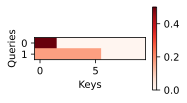

In [18]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [30]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]  #token的embedding长度,超参数
        # 设置transpose_b=True为了交换keys的最后两个维度,做内积
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [35]:
keys.shape,values.shape,valid_lens

(torch.Size([2, 10, 2]), torch.Size([2, 10, 4]), tensor([2, 6]))

In [36]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


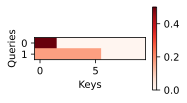

In [37]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
1. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？


In [40]:
queries,keys=torch.normal(0,1,(2,1,20)),torch.normal(0,1,(2,10,2))
values=torch.arange(40,dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens=torch.tensor([2,6])
attention=AdditiveAttention(key_size=2,query_size=20,num_hiddens=8,dropout=0.1)
attention.eval()
attention(queries,keys,values,valid_lens)

tensor([[[ 1.9602,  2.9602,  3.9602,  4.9602]],

        [[10.1169, 11.1169, 12.1169, 13.1169]]], grad_fn=<BmmBackward0>)

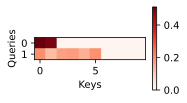

In [41]:
d2l.show_heatmaps(attention.attention_weights.reshape(1,1,2,10),xlabel='Keys',ylabel='Queries')
#

In [42]:
queries=torch.normal(0,1,(2,1,2))
attention=DotProductAttention(dropout=0.5)
attention.eval()
attention(queries,keys,values,valid_lens)

tensor([[[ 0.9399,  1.9399,  2.9399,  3.9399]],

        [[ 9.8925, 10.8925, 11.8925, 12.8925]]])

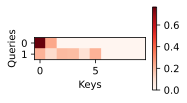

In [43]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')


[Discussions](https://discuss.d2l.ai/t/5752)
